# COHORT 분석
## COHORT 분석의 정의와 활용 방법
### 코호트 분석의 정의
- 코호트 분석이란 **특정 기간 동안 일정한 기준으로 동일하게 묶을 수 있는 사용자들의 집단을 분석**하는 기법.
- 가장 흔하게 쓰이는 방법은 특정 날짜를 기준으로 사용자들을 하나의 집단으로 묶어 이들의 행동을 분석하는 것.

### 코호트 분석을 하는 이유
- 가장 핵심은 '왜 고객들을 하나의 집단으로 묶는가'를 아는 것
- **고객들의 Exit Rate와 Retention Rate(재방문율 혹은 재구매율)을 파악**하여 정기적으로 문제를 진단하고, 해결 전략을 도출하기 위한 대시 보드로 많이 활용
- 고객집단 별 고객 생애 가치를 계산, 서비스의 고착도를 판단할 수 있는 중요 수단으로 활용
    - ex) 5월 가정의 달 프로모션으로 가입한 고객들은 얼마나 서비스에 남아 있고, 총소비를 얼마나 하는지 파악하는데 최적화 된 답 도출 가능

## 코호트 분석의 순서와 코드(python)
### Step1. 코호트 분석의 목적 설정
- **무엇을 보기 위해서 그들을 하나의 집단으로 묶는가를 명확히 인지**
    - 목표1. 월별로 소비자들의 재구매율을 판단하여, **2~3달 이내에 가장 많이 이탈한 집단을 도출**
    - 목표2. 소비자 집단별로 **수익석을 판단하여, 어떤 Group의 재방문 및 재구매율을 촉진시켜야 하는지 선정**

### Step2. 사전 준비 작업 진행 - 패키지 및 데이터 불러오기

In [35]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# 데이터 불러오기
df = pd.read_excel('https://github.com/springcoil/marsmodelling/blob/master/relay-foods.xlsx?raw=true', 
                 sheet_name='Purchase Data - Full Study')
print(df.head())

   OrderId  OrderDate  UserId  TotalCharges CommonId  PupId PickupDate
0      262 2009-01-11      47         50.67    TRQKD      2 2009-01-12
1      278 2009-01-20      47         26.60    4HH2S      3 2009-01-20
2      294 2009-02-03      47         38.71    3TRDC      2 2009-02-04
3      301 2009-02-06      47         53.38    NGAZJ      2 2009-02-09
4      302 2009-02-06      47         14.28    FFYHD      2 2009-02-09


- 기본 데이터 설명
    - Order ID : 주문 마다 발생하는 고유의 코드
    - Order Date : 주문이 발생한 날짜를 의미
    - User ID : 고객마다 갖고 있는 고유의 아이디
    - Total Charge : 주문에서 발생한 총 비용을 의미
    - 다른 Column은 사용 안함

### Step3. 데이터 전처리
- 불필요한 Column 삭제
- 구매주기를 월별로 계산할 수 있는 날짜 형식 치환
    - 월별 소비자 집단을 규정하기 위해 date -> Month로 치환
    - 날짜를 "OrderCycle" column에 삽입

In [36]:
df = df.drop(['CommonId', 'PupId', 'PickupDate'], axis = 1)

df['OrderCycle'] = df['OrderDate'].dt.strftime('%Y-%m')

print(df.head(3))

   OrderId  OrderDate  UserId  TotalCharges OrderCycle
0      262 2009-01-11      47         50.67    2009-01
1      278 2009-01-20      47         26.60    2009-01
2      294 2009-02-03      47         38.71    2009-02


### Step4. 코호트 분석에 필요한 변수 생성
- 고객별 첫 구매가 언제 이루어졌는지 파악

In [37]:
# 최초 구매일 계산
first_order = df.groupby('UserId').OrderDate.min()
first_order = first_order.dt.strftime('%Y-%m')
print(first_order.head())

UserId
47     2009-01
95     2009-03
98     2009-01
112    2009-01
141    2009-11
Name: OrderDate, dtype: object


- 첫 구매 데이터 기존 데이터에 붙이기

In [38]:
# 기존 데이터 Index를 UserId로 전환
df = df.set_index('UserId')

df['FirstOrder'] = first_order

# Index 정상화
df.reset_index(inplace = True)

print(df.head())


   UserId  OrderId  OrderDate  TotalCharges OrderCycle FirstOrder
0      47      262 2009-01-11         50.67    2009-01    2009-01
1      47      278 2009-01-20         26.60    2009-01    2009-01
2      47      294 2009-02-03         38.71    2009-02    2009-01
3      47      301 2009-02-06         53.38    2009-02    2009-01
4      47      302 2009-02-06         14.28    2009-02    2009-01


### Step5. 월별로 구매 고객 데이터 치환
- 월별로 구매 고객을 볼 때 2가지 데이터를 계산
    - 1. 주기별 구매한 User의 수
    - 2. 주기별 구매한 금액의 계산

In [39]:
# 주기별 구매 User 계산
co1 = df.groupby(['FirstOrder', 'OrderCycle']).UserId.nunique()
co1 = co1.reset_index()
co1.rename({'UserId' : 'TotalUsers'}, axis = 1, inplace = True)
# print(co1.head())

# 주기별 구매 금액 계산
co2 = df.groupby(['FirstOrder', 'OrderCycle']).TotalCharges.sum()
co2 = co2.reset_index()
co2.rename({'TotalCharges' : 'PurchaseAmnt'}, axis = 1, inplace = True)
# print(co2.head())

co = co1.merge(co2, on = ['FirstOrder', 'OrderCycle'])
print(co.head())

  FirstOrder OrderCycle  TotalUsers  PurchaseAmnt
0    2009-01    2009-01          22      1850.255
1    2009-01    2009-02           8      1351.065
2    2009-01    2009-03          10      1357.360
3    2009-01    2009-04           9      1604.500
4    2009-01    2009-05          10      1575.625


### Step6. 코호트 기준 계산 및 데이터 형태 최종 완성
- 코호트 기간 기준 계산 방법
    - **모든 Row에서 월차수를 구하는 코드를 for 문을 통해 게산**

In [40]:
temp = []

for i in range(co.shape[0]):
    f_first_order = pd.to_datetime(co.FirstOrder[i]).to_period('M')
    f_order_cycle = pd.to_datetime(co.OrderCycle[i]).to_period('M')
    
    month_diff = (f_order_cycle - f_first_order).n
    
    temp.append(month_diff)

co['CohortPeriod'] = temp
print(co.head())

  FirstOrder OrderCycle  TotalUsers  PurchaseAmnt  CohortPeriod
0    2009-01    2009-01          22      1850.255             0
1    2009-01    2009-02           8      1351.065             1
2    2009-01    2009-03          10      1357.360             2
3    2009-01    2009-04           9      1604.500             3
4    2009-01    2009-05          10      1575.625             4


#### 코호트 데이터 형태 최종 완성
- Pandas Unstack 활용
    - pd.stack은 Column에 있는 값들을 index로 변환
    - pd.unstack은 index에 있는 값들을 column으로 변환
- ex)
    - co.TotalUsers.unctack(1)
        - TotalUsers 값을 기준으로 계산
        - 인덱스 중 2번째 인덱스(CohortPeriod)를 Column으로 이동

In [43]:
# 재방문율 계산을 위한 Pandas Unstack 활용
co_retention = co.set_index(['FirstOrder', 'CohortPeriod'])
co_retention = co_retention.TotalUsers.unstack(1)
retention = co_retention.div(co_retention[0], axis = 0)

# 구매 규모 형태 치환을 위해 Pandas Unstack 활용
co_purchase = co.set_index(['FirstOrder', 'CohortPeriod'])
co_purchase = co_purchase.PurchaseAmnt.unstack(1)

CohortPeriod        0         1        2        3          4          5   \
FirstOrder                                                                 
2009-01       1850.255  1351.065  1357.36  1604.50  1575.6250  1384.8400   
2009-02        666.310   501.610   968.78    53.36   758.5200   667.1000   
2009-03        806.310   463.800  1108.21   902.71   161.2500  1010.8000   
2009-04       2561.250  1189.580  1085.38   987.13   474.0100   531.3825   
2009-05       2627.560  1146.830   648.21   381.15   415.5969   389.0605   

CohortPeriod         6          7          8         9          10         11  \
FirstOrder                                                                      
2009-01       1750.8400  1426.5714  1964.2755  860.3292  1821.8153  2152.1165   
2009-02        314.1752   567.5057   328.2800  738.9359   263.1971   550.0098   
2009-03       1256.4672  1067.9247   905.3610  485.9966   897.1602   642.1517   
2009-04        209.4465   339.1139   147.3250  445.5447   634.

### Step7. 코호트 분석 시각화
- **코호트 분석 시각화시 활용하면 좋은 패키지는 Seaborn 중 heatmap**

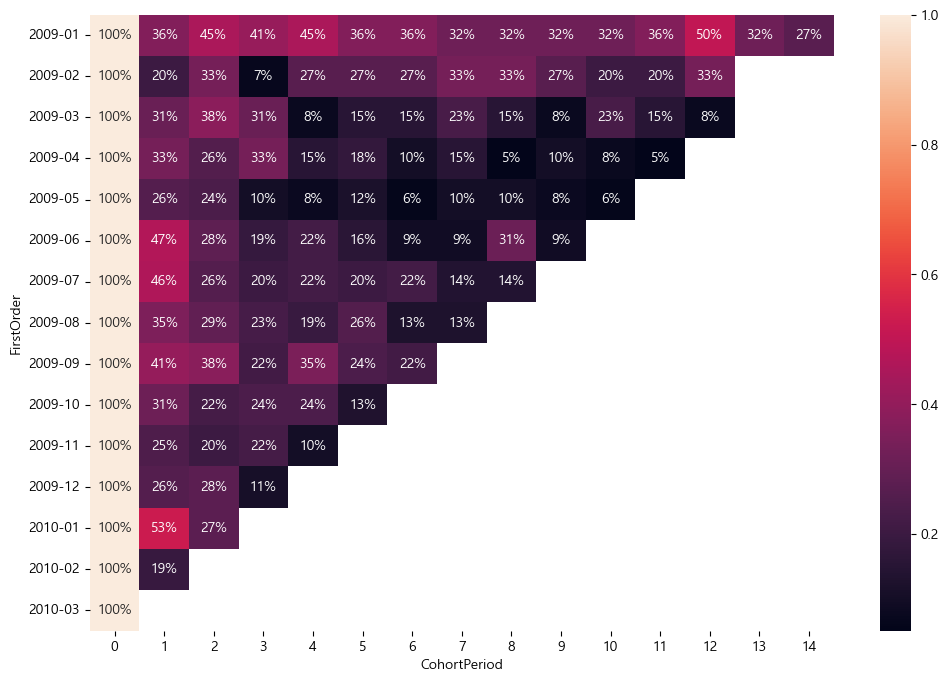

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

# 재방문율 시각화
plt.rcParams['figure.figsize'] = (12, 8)
sns.heatmap(retention, annot = True, fmt = '.0%')
plt.show()

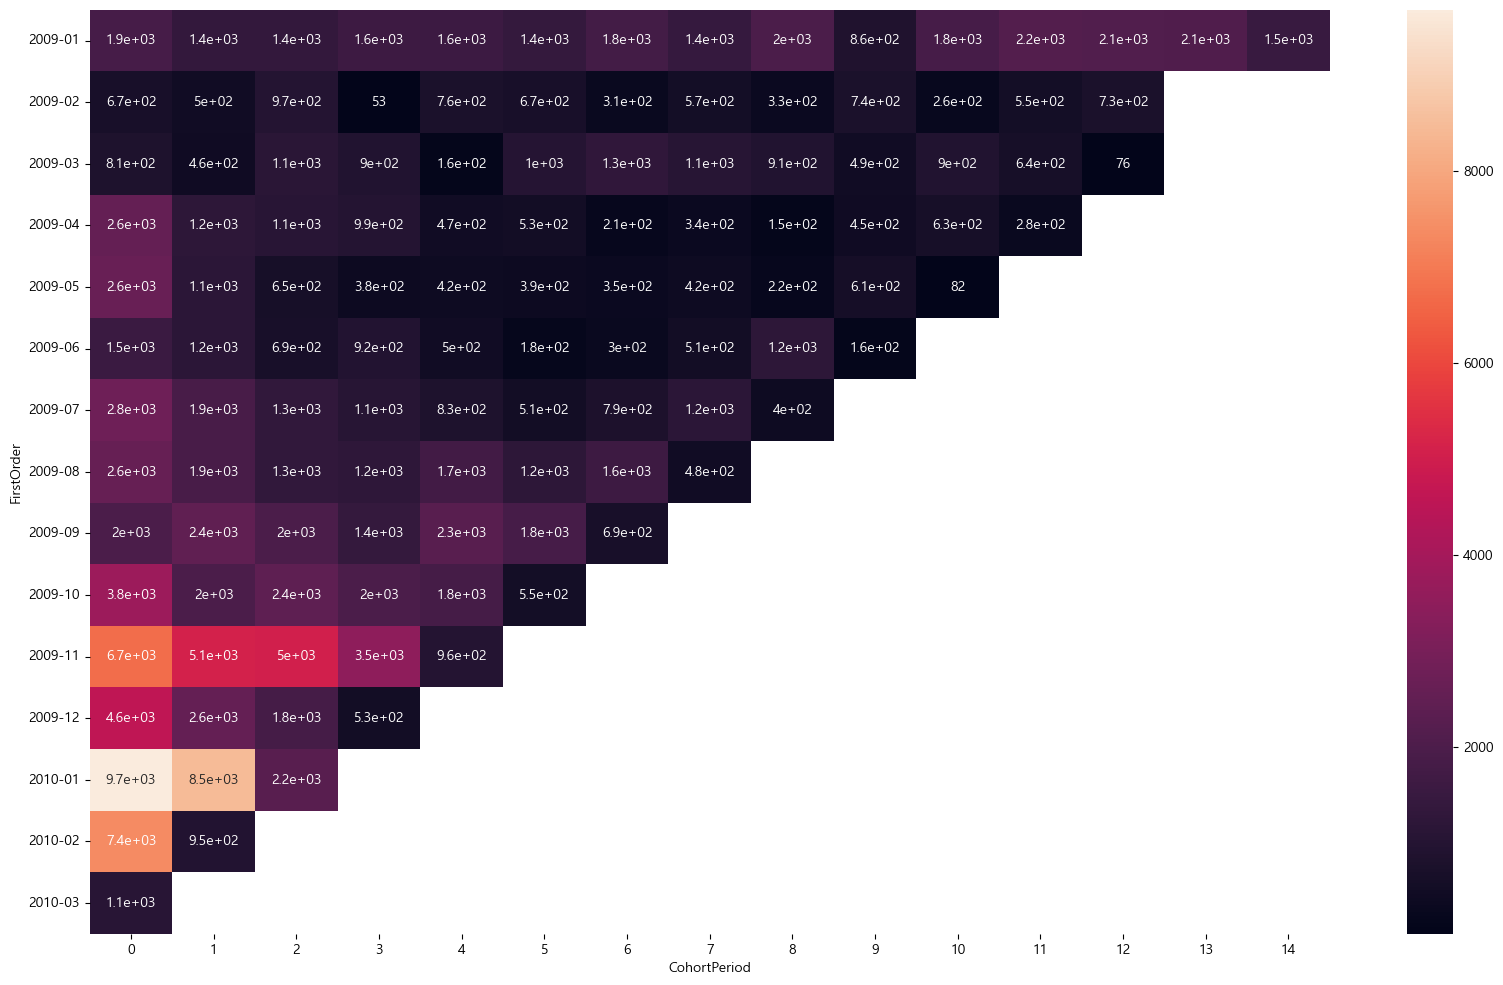

In [56]:
# 구매 규모 시각화
plt.rcParams['figure.figsize'] = (20, 12)
sns.heatmap(co_purchase, annot = True)
plt.yticks(rotation = 360)
plt.show()

## 코호트 분석 해석
- 코호트 기간을 1로 고정했을 때

In [67]:
cohort_1_retention = retention[1]
cohort_1_purchase = co_purchase[1]

cohort_1 = pd.DataFrame({'retention' : cohort_1_retention, 'purchase' : cohort_1_purchase})

cohort_1.sort_values('retention').sort_values('purchase', ascending = False)

,retention,purchase
FirstOrder,,
2010-01,0.526316,8453.1039
2009-11,0.246154,5107.4213
2009-12,0.261538,2565.4410
2009-09,0.405405,2433.3013
2009-10,0.314815,1957.8872
2009-08,0.354839,1869.4376
2009-07,0.460000,1858.3499
2009-01,0.363636,1351.0650
2009-04,0.333333,1189.5800


- 2009년 11월 달의 구매자를 보면 재 구매율이 25% 정도로 이탈이 많은 집단인데 매출이 2순위로 기록 될 만큼 가장 큰 구매력이 있는 집단이다.
- 따라서 **이 집단의 고객들이 서비스에 남아있지 않고 이탈하여 장기적인 수익을 놓치고 있는 상황이라는 것을 유추**해 볼 수 있다